In [2]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow, cv2
%matplotlib inline

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 2020

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')


In [3]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setting the current working directory
import os; os.chdir('/content/drive/My Drive/data/CV2')

1. Unzip, read and Load data(‘PINS.zip’) into session

In [5]:
!ls


'Benedict Cumberbatch9.jpg'   PINS.zip
'Dwayne Johnson4.jpg'	      testimages
 images.npy		      training_images
 __MACOSX		      training_images-20211126T092819Z-001.zip
 PINS			      vgg_face_weights.h5


Extract Aligned Face Dataset from PINS.zip


In [ ]:
with ZipFile('PINS.zip', 'r') as zip:
  zip.extractall()

2. Write function to create metadata of the image.
3. Write a loop to iterate through each and every image and create metadata for all the images

In [6]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    exts = []
    print("The path before For Loop",path)
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

The path before For Loop PINS


In [7]:
type(metadata)

numpy.ndarray

In [8]:
metadata

array([PINS/pins_mark zuckerberg/mark zuckerberg1.jpg,
       PINS/pins_mark zuckerberg/mark zuckerberg50.jpg,
       PINS/pins_mark zuckerberg/mark zuckerberg44.jpg, ...,
       PINS/pins_tati gabrielle/tati gabrielle21.jpg,
       PINS/pins_tati gabrielle/tati gabrielle20.jpg,
       PINS/pins_tati gabrielle/tati gabrielle34.jpg], dtype=object)

In [9]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [10]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

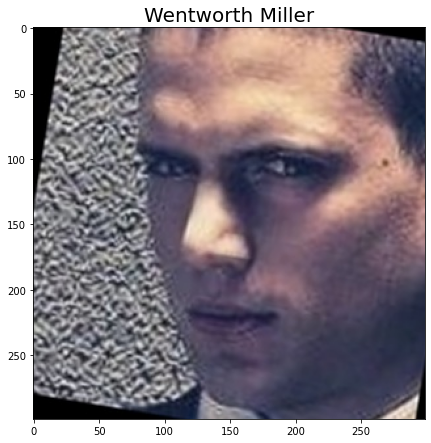

In [11]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

4.Generate Embeddings vectors on the each face in the dataset.

VGG Face model


In [12]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model


Load the model
Load the model defined above
Then load the given weight file named "vgg_face_weights.h5"

In [13]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

Get vgg_face_descriptor


In [14]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)


Generate embeddings for each image in the dataset


In [15]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 8s 8s/step
(2622,)


Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [16]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


5. Build distance metrics for identifying the distance between two similar and dissimilar images.

Consider distance metric as "Squared L2 distance"
Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [17]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [18]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

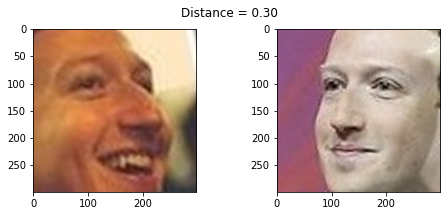

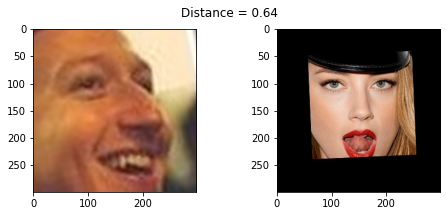

In [19]:
show_pair(2, 3)
show_pair(2, 180)

6. Use PCA for dimensionality reduction

Create train and test sets
Create X_train, X_test and y_train, y_test
Use train_idx to seperate out training features and labels
Use test_idx to seperate out testing features and labels
tra

In [20]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

Encode the Labels
Encode the labels
Use LabelEncoder

In [21]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

Standardize the feature values
Scale the features using StandardScaler

In [22]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


Reduce dimensions using PCA
Reduce feature dimensions using Principal Component Analysis

In [23]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.56425221  18.95823498  22.93300641 ...  99.99999983  99.99999999
 100.        ]


In [24]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 347


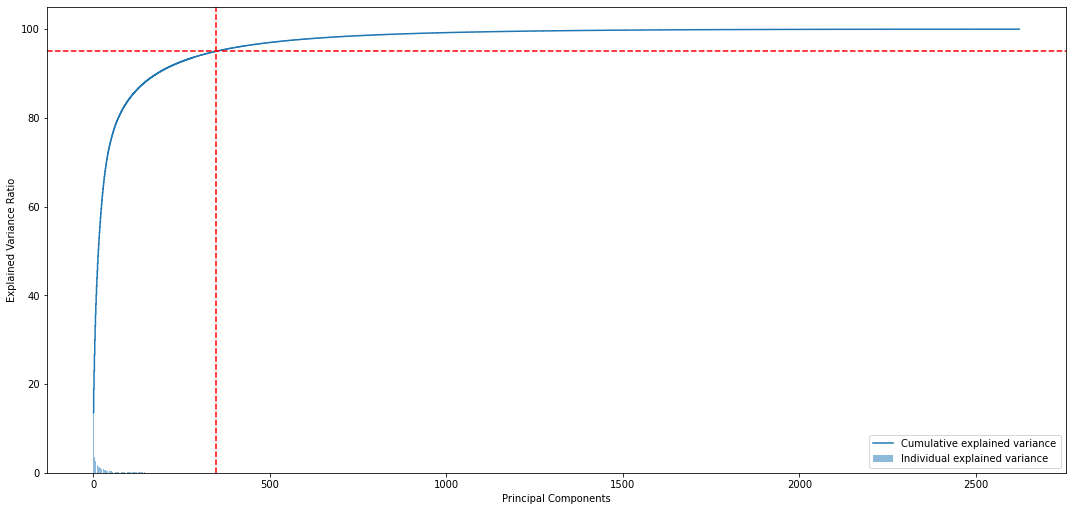

In [25]:
#Ploting 
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [26]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

7. Build an SVM classifier in order to map each image to its right person. 

Use SVM Classifier to predict the person in the given image
Fit the classifier and print the score

In [27]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.995


In [28]:
# Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.965


In [29]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       1.00      1.00      1.00        10
            Alvaro Morte       1.00      0.93      0.96        14
Alycia Debnam Carey Face       1.00      0.92      0.96        12
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      0.93      0.96        14
           Anne Hathaway       1.00      0.92      0.96        13
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       1.00      0.92      0.96        13
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.91      1.00      

8. Import and display the the test images.

2 Images stored in testimages folder

In [30]:
ls

'Benedict Cumberbatch9.jpg'   PINS.zip
'Dwayne Johnson4.jpg'         testimages/
 images.npy                   training_images/
 __MACOSX/                    training_images-20211126T092819Z-001.zip
 PINS/                        vgg_face_weights.h5


In [31]:
os.path

<module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>

In [32]:
metadata_test, exts_test = load_metadata('testimages')
labels_test = np.array([meta.name for meta in metadata_test])


The path before For Loop testimages


In [33]:
print(metadata_test)

[testimages/Dwayne Johnson/Dwayne Johnson4.jpg
 testimages/Benedict Cumberbatch/Benedict Cumberbatch9.jpg]


In [34]:
print(labels_test)

['Dwayne Johnson' 'Benedict Cumberbatch']


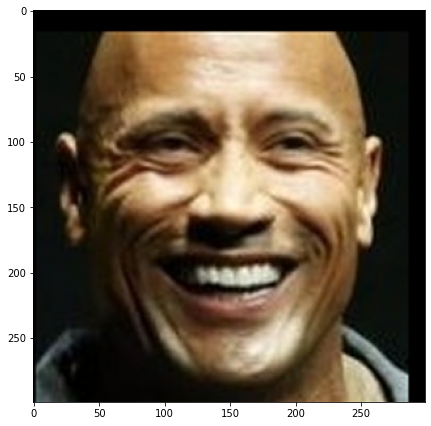

In [50]:
n = 0
img_path = metadata_test[n].image_path()
img = load_image(img_path)
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
_ = plt.imshow(img)

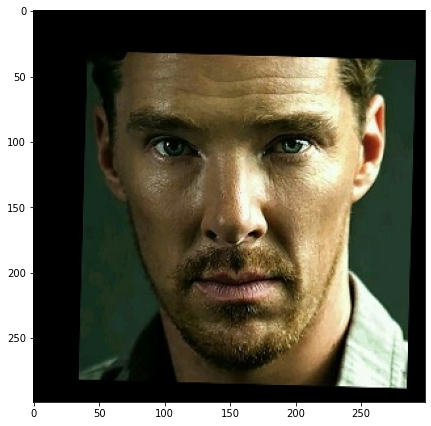

In [51]:
n = 1
img_path = metadata_test[n].image_path()
img = load_image(img_path)
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
_ = plt.imshow(img)

9. Use the trained SVM model to predict the face on both test images. [4 Marks]

Create X, Y from Test Images Folder

In [52]:
test_idx = np.arange(metadata_test.shape[0]) 


In [53]:
test_idx

array([0, 1])

In [54]:
X_test = np.array(embeddings)[test_idx]


In [55]:
X_test_sc = sc.transform(X_test)


In [56]:
X_test_sc.shape

(2, 2622)

In [57]:
X_test_pca = pca.transform(X_test_sc)


In [58]:
X_test_pca.shape

(2, 347)

In [59]:
X_train_pca.shape

(9573, 347)

In [60]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata_test[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata_test[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 0s 23ms/step


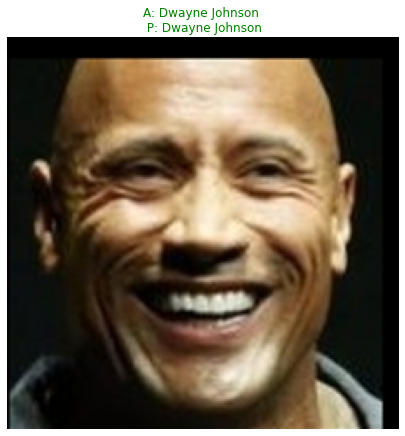

In [61]:
sample_img, actual_name, pred_name = sample_img_plot(0)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 [==============================] - 0s 22ms/step


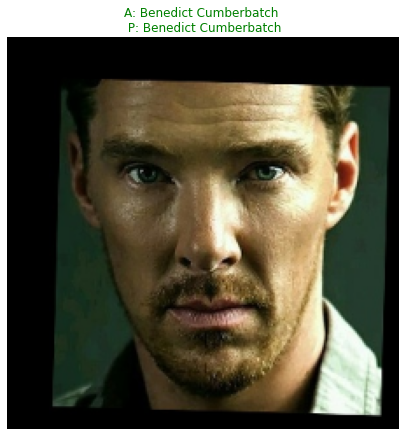

In [62]:
sample_img, actual_name, pred_name = sample_img_plot(1)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()